In [1]:
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# Load Dataset

In [2]:
car_images = []
noncar_images = []

In [3]:
# option 1 (using os)
for root, dirs, files in os.walk('./dataset/vehicles/vehicles/'):
    for file in files:
        if file.endswith('.png'):
            car_images.append(os.path.join(root, file))

for root, dirs, files in os.walk('./dataset/non-vehicles/non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            noncar_images.append(os.path.join(root, file))
print(len(car_images), len(noncar_images))

8792 8968


In [4]:
# option 2 (using glob)
car_images = glob.glob('./dataset/vehicles/**/**/*.png')
noncar_images = glob.glob('./dataset/non-vehicles/**/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


# Basic Summary

In [5]:
img = cv2.imread(car_images[0])
print('No. of car images : ', len(car_images))
print('No. of non-car images : ', len(noncar_images))
print('image shape : ', img.shape)

No. of car images :  8792
No. of non-car images :  8968
image shape :  (64, 64, 3)


# Visualize

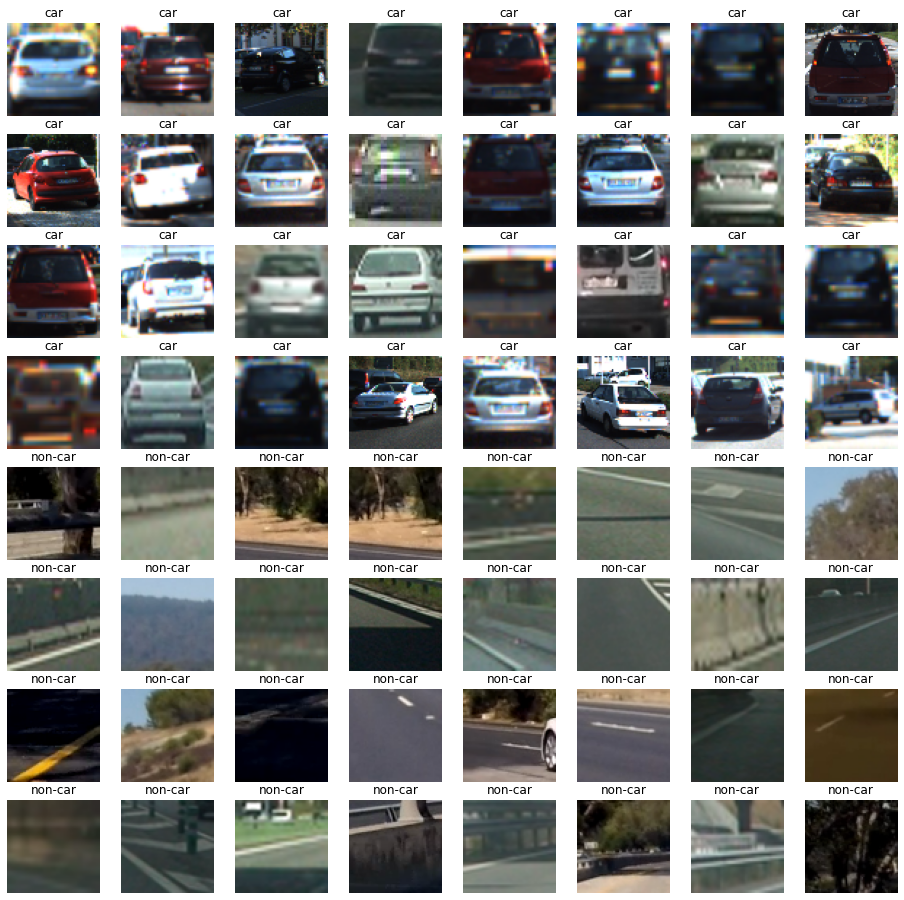

In [6]:
figure, ax = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))
ax = ax.flatten()
for i in range(32):
    rand_i = np.random.randint(len(car_images))
    image = mpimg.imread(car_images[rand_i])
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title('car')

for i in range(32, 64):
    rand_i = np.random.randint(len(noncar_images))
    image = mpimg.imread(noncar_images[rand_i])
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title('non-car')

# Feature Extraction

* Color and Shape : Raw pixel(resize)
* Color Only : Histogram of pixel value
* Shape Only : Histogram of oriened gradients (HOG)

In [7]:
def resized_raw_pixel(img, size=(32, 32)):
    # resize된 이미지를 flatten
    return cv2.resize(img, size).ravel()

def color_histogram(img, nbins=32, bins_range=(0, 256)):
    # 각 채널별 히스토그램을 구해서 연결 후 return
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def get_hog_feature(img_channel, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block = (2, 2), block_norm = 'L2-Hys',
                            transform_sqrt = False, visualize=True, feature_vector=True):
    # 입력된 채널에 대해 HOG Feature Vecture return
    hog_features, _ = hog(img_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block = cells_per_block,
                            block_norm = block_norm,
                            transform_sqrt = transform_sqrt,
                            visualize=visualize, feature_vector=feature_vector)
    return hog_features


In [8]:
def extract_features(file_paths, orientations, pixels_per_cell,
                            cells_per_block, block_norm, transform_sqrt,
                            visualize, feature_vector, spatial_size,
                            hist_bins, bins_range):
    features = []

    for file_path in file_paths:
        image = mpimg.imread(file_path)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        # 1. HOG feature
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feature = get_hog_feature(feature_image[:, :, channel], orientations, pixels_per_cell,
                            cells_per_block, block_norm,
                            transform_sqrt, visualize, feature_vector)
            hog_features.append(hog_feature)
        hog_features = np.ravel(hog_features)
        # 2. Resize feature
        resized_features = resized_raw_pixel(feature_image, size=spatial_size)

        # 3. Color histogram
        hist_features = color_histogram(feature_image, hist_bins, bins_range)

        # 1 + 2 + 3
        features.append(np.concatenate((resized_features, hist_features, hog_features)))

    return features


In [9]:
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = 'L2-Hys'
transform_sqrt = False
visualize = True
feature_vector = True
spatial_size = (32, 32)
hist_bins = 32
bins_range = (0, 256)

car_features = extract_features(car_images, orientations, pixels_per_cell,
                            cells_per_block, block_norm, transform_sqrt,
                            visualize, feature_vector, spatial_size,
                            hist_bins, bins_range)
noncar_features = extract_features(noncar_images, orientations, pixels_per_cell,
                            cells_per_block, block_norm, transform_sqrt,
                            visualize, feature_vector, spatial_size,
                            hist_bins, bins_range)
print(len(car_features), len(noncar_features))

8792 8968


In [10]:
car_features[0].shape, noncar_features[0].shape

((8460,), (8460,))

# Data Preparation

In [11]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [12]:
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_train, X_test, y_train, y_test  = train_test_split(X_std, y, test_size=0.2, random_state=0)

In [13]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [14]:
from sklearn.metrics import accuracy_score
preds = svm.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

0.9881756756756757


In [15]:
svm_ = LinearSVC(C=1.0)
svm.fit(X_train, y_train)
preds = svm.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

0.9881756756756757
